In [1]:
%pip install bayesian-optimization
%pip install livelossplot

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=648eec46c29623b03a4e8809ec74642d3458bd72e69f5428f0411760a94640d2
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os, contextlib, sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import explained_variance_score, r2_score
from sklearn.preprocessing import quantile_transform, StandardScaler, RobustScaler
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, f_regression
from livelossplot import PlotLosses

In [4]:
%cd /content/drive/My\ Drive/Colab\ Notebooks
from laplotter import LossAccPlotter

/content/drive/My Drive/Colab Notebooks


In [0]:
np.random.seed(seed=1)

In [0]:
gpu = torch.device("cuda:0")

In [0]:
names_train = list()
names_test = list()
def loaddata(directory):
    feature_list = list()
    train_data_list = list()
    train_target_list = list()
    for i,filename in enumerate(os.listdir(directory)):
        data_matrix = np.genfromtxt(f'{directory}/{filename}')        
        if i==0: 
            raw_data = np.genfromtxt('data/etalon_etalon_29May20.ccfSum-telemetry.csv',delimiter=',',names=True)
            feature_list.append(list(raw_data.dtype.names))
            train_data_list.append(data_matrix[:,[i for i in range(len(data_matrix[1])) if i!=1]])
            train_target_list.append(data_matrix[:,1])
            names_train.append(filename)
        elif i==len(os.listdir(directory))-2:
            test_data = data_matrix[:,[i for i in range(len(data_matrix[1])) if i!=1]]
            test_target = data_matrix[:,1]
            names_test.append(filename)
        else:
            train_data_list.append(data_matrix[:,[i for i in range(len(data_matrix[1])) if i!=1]])
            train_target_list.append(data_matrix[:,1])
            names_train.append(filename)
    feature_list = feature_list[0]
    feature_list.remove('RV')
    return train_data_list, train_target_list, test_data, test_target, np.array(feature_list,dtype=str)

def get_explained(model, data, target):
    model.eval()
    pred = model(data).squeeze().detach().numpy()
    target = target.detach().numpy()

    return explained_variance_score(target, pred), r2_score(target, pred)

In [0]:
class LSTMTagger(nn.Module):

    def __init__(self, inputsize, layers, hiddensize, drop_out):
        super(LSTMTagger, self).__init__()
        self.inputsize = inputsize
        self.hiddensize = hiddensize
        self.layers = layers
        self.drop_out = drop_out

        self.lstm = nn.LSTM(input_size=self.inputsize, hidden_size = self.hiddensize, num_layers=layers, dropout=drop_out)
        self.hidden2radial = nn.Linear(in_features=hiddensize, out_features=1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = F.elu(x)
        x = self.hidden2radial(x)
        return x

In [0]:
def crossval(n_epochs,layers,hiddensize,drop_out, lr, weightd):
    criterion = nn.MSELoss()
    judge = list()
    for i,valdata in enumerate(train_data_torch):
          model = LSTMTagger(3,layers=layers, hiddensize=hiddensize,drop_out=drop_out).to(gpu)
          optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=weightd)

          traindata = train_data_torch[:i] + train_data_torch[i+1:]
          traintarget = train_target_torch[:i] + train_target_torch[i+1:]
          valtarget = train_target_torch[i]
          judge_list = list()

          plotlosses = PlotLosses()
          for e in range(n_epochs):
              model.train()
              epoch_losses = list()
              epoch_evs = list()
              acc_list = list()
              loss_list = list()
              for batch in range(len(traindata)):
                  model.zero_grad()
                  optimizer.zero_grad() 
                  prediction = model(traindata[batch])
                  target = traintarget[batch]
                  # Calculating the loss function
                  loss = criterion(prediction.squeeze(dim=2), target)
                  # Calculating the gradient
                  loss.backward()
                  optimizer.step()
              with torch.no_grad():
                  model.eval()
                  train_prediction = model(valdata).squeeze(dim=1)
                  loss_list.append( float(criterion((train_prediction),valtarget).detach().cpu()) )
                  acc_list.append( explained_variance_score(valtarget.cpu(), train_prediction.cpu()) )
              plotlosses.update({'acc': np.mean(acc_list), 'loss': np.mean(loss_list)})
              plotlosses.send()
              judge_list.append(np.mean(acc_list))
          judge.append([np.mean(judge_list),model])
    sorted(judge, key=lambda x: x[0])
    winner = judge[0]
    return winner[1]

In [0]:
def allval(n_epochs,layers,hiddensize,drop_out, lr,weightd):
    criterion = nn.MSELoss()
    model = LSTMTagger(27,layers=layers, hiddensize=hiddensize,drop_out=drop_out).to(gpu)
    optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=weightd)

    traindata = train_data_torch
    traintarget = train_target_torch

    model.train()
    plotlosses = PlotLosses()
    for e in range(n_epochs):
        epoch_losses = list()
        epoch_evs = list()
        acc_list = list()
        loss_list = list()
        for batch in range(len(traindata)):
            model.zero_grad()
            optimizer.zero_grad() 
            prediction = model(traindata[batch])
            target = traintarget[batch]
            # Calculating the loss function
            loss = criterion(prediction.squeeze(dim=2), target)
            epoch_losses.append(float(loss))
            evs = explained_variance_score(target.squeeze(dim=1).detach().cpu().numpy(),prediction.squeeze(dim=1).detach().cpu().numpy())
            epoch_evs.append(evs)
            # Calculating the gradient
            loss.backward()
            optimizer.step()
        plotlosses.update({'acc': np.mean(epoch_evs), 'loss': np.mean(epoch_losses)})
        plotlosses.send()
    return model

In [0]:
train_data_list, train_target_list, test_data, test_target, feature_list = loaddata('Scaleddata')

In [0]:
kindex = np.where((feature_list == 'FIES_INSIDE_BLACK_BOX_AT_REAR') | (feature_list == 'FIES_INSIDE_BLACK_BOX_CENTRE') | (feature_list == 'JD_UTC'))
feature_list = feature_list[kindex]
train_data_list_k = [i[:,kindex].squeeze() for i in train_data_list]
test_data_k = test_data[:,kindex].squeeze()

In [0]:
train_data_list_k = [quantile_transform(data,n_quantiles=100,copy=True) for data in train_data_list_k]
test_data_k = quantile_transform(test_data_k,n_quantiles=100,copy=True)

In [0]:
train_data_torch = [torch.from_numpy(data).unsqueeze(dim=1).float().to(gpu) for data in train_data_list_k]
train_target_torch = [torch.from_numpy(data).unsqueeze(dim=1).float().to(gpu) for data in train_target_list]
test_data_torch, test_target_torch = torch.from_numpy(np.array(test_data_k)).unsqueeze(dim=1).float().to(gpu), torch.from_numpy(np.array(test_target)).float().to(gpu)

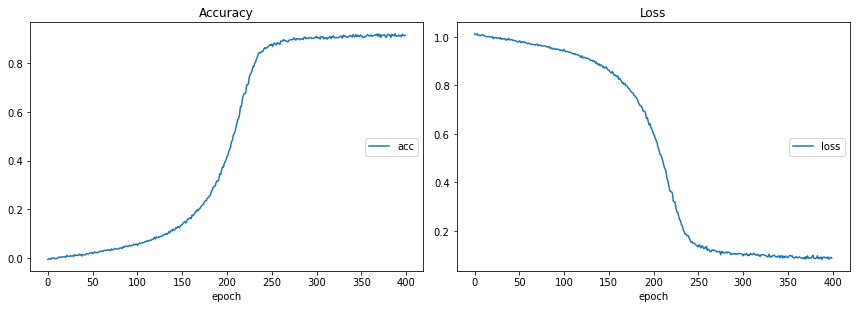

Accuracy
	acc              	 (min:   -0.006, max:    0.920, cur:    0.914)
Loss
	loss             	 (min:    0.082, max:    1.013, cur:    0.088)


In [0]:
model = allval(300,layers=2,hiddensize=200,drop_out=0.7, lr=0.00001, weightd=1e-3)

In [0]:
def plot(test,number=0):
    if test == True:
      time = test_data[:,0]
      data_plot = test_data_torch
      RV_true = test_target_torch.cpu().numpy()
      RV_errorbar = test_data[:,2]
      title = f'{names_test[0]}'
    elif test == False:
      data_plot = train_data_torch[number]
      all_data = train_data_list[number]
      time = all_data[:,0]
      RV_true = train_target_torch[number].cpu().numpy()
      RV_errorbar = all_data[:,2]
      title = f'{names_train[i]}'
    RV_pred = model(data_plot).squeeze(dim=2).detach().cpu().numpy()
    print( explained_variance_score(RV_true,RV_pred) )
    plt.plot(time,RV_pred,'r-',label='Predicted')
    plt.plot(time,RV_true, color='k', label='True')
    plt.legend()
    plt.show()

0.9083045125007629


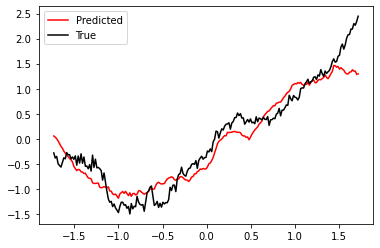

0.9166796207427979


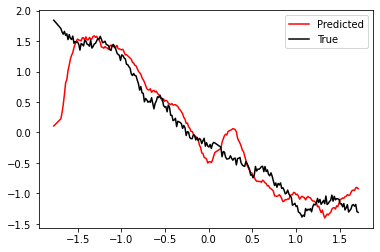

0.5885151624679565


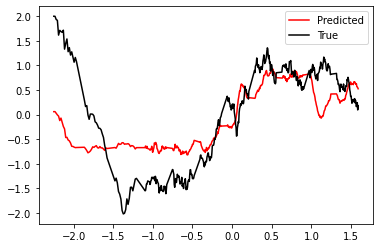

In [0]:
for i in range(2):
  plot(False,i)
plot(True)